# Hotel Price Prediction using Neural Networks

## Importing the libraries

In [123]:
import os, pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

pathlib.Path('./models/HotelPricePrediction/').mkdir(
    parents=True, exist_ok=True)
pathlib.Path('./results/HotelPricePrediction/').mkdir(
    parents=True, exist_ok=True)
MODELS_DIR = pathlib.Path('./models/HotelPricePrediction/')
RESULTS_DIR = pathlib.Path('./results/HotelPricePrediction/')
DATA_DIR = pathlib.Path('./data/HotelPricePrediction/')

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Preprocessing the data

### Splitting the targets from the data

In [3]:
train_data = pd.read_csv(os.path.join(DATA_DIR, 'trainingset.csv'))
train_targets = train_data['ADR']
train_data.drop(columns=['ADR'], inplace=True)

test_data = pd.read_csv(os.path.join(DATA_DIR, 'testset.csv'))
test_targets = test_data['ADR']
test_data.drop(columns=['ADR'], inplace=True)


In [4]:
train_data.shape, test_data.shape

((40060, 27), (79330, 27))

### Replace the missing values with the maximum number of the column

In [5]:
train_data.isna().sum()

IsCanceled                       0
LeadTime                         0
ArrivalDateYear                  0
ArrivalDateMonth                 0
ArrivalDateWeekNumber            0
ArrivalDateDayOfMonth            0
StaysInWeekendNights             0
StaysInWeekNights                0
Adults                           0
Children                         0
Babies                           0
Meal                             0
Country                        464
MarketSegment                    0
DistributionChannel              0
IsRepeatedGuest                  0
PreviousCancellations            0
PreviousBookingsNotCanceled      0
ReservedRoomType                 0
AssignedRoomType                 0
BookingChanges                   0
DepositType                      0
DaysInWaitingList                0
CustomerType                     0
RequiredCarParkingSpaces         0
TotalOfSpecialRequests           0
ReservationStatus                0
dtype: int64

In [6]:
train_data['Country'].value_counts()

PRT    17630
GBR     6814
ESP     3957
IRL     2166
FRA     1611
       ...  
BIH        1
MUS        1
COM        1
UGA        1
DJI        1
Name: Country, Length: 125, dtype: int64

In [7]:
train_data['Country'][train_data['Country'].isna()]

30       NaN
4127     NaN
7092     NaN
7860     NaN
8779     NaN
        ... 
26473    NaN
28460    NaN
31085    NaN
31594    NaN
33087    NaN
Name: Country, Length: 464, dtype: object

In [8]:
train_data['Country'].fillna('PRT', inplace=True)

In [9]:
train_data.isna().sum()

IsCanceled                     0
LeadTime                       0
ArrivalDateYear                0
ArrivalDateMonth               0
ArrivalDateWeekNumber          0
ArrivalDateDayOfMonth          0
StaysInWeekendNights           0
StaysInWeekNights              0
Adults                         0
Children                       0
Babies                         0
Meal                           0
Country                        0
MarketSegment                  0
DistributionChannel            0
IsRepeatedGuest                0
PreviousCancellations          0
PreviousBookingsNotCanceled    0
ReservedRoomType               0
AssignedRoomType               0
BookingChanges                 0
DepositType                    0
DaysInWaitingList              0
CustomerType                   0
RequiredCarParkingSpaces       0
TotalOfSpecialRequests         0
ReservationStatus              0
dtype: int64

In [10]:
test_data.isna().sum()

IsCanceled                      0
LeadTime                        0
ArrivalDateYear                 0
ArrivalDateMonth                0
ArrivalDateWeekNumber           0
ArrivalDateDayOfMonth           0
StaysInWeekendNights            0
StaysInWeekNights               0
Adults                          0
Children                        4
Babies                          0
Meal                            0
Country                        24
MarketSegment                   0
DistributionChannel             0
IsRepeatedGuest                 0
PreviousCancellations           0
PreviousBookingsNotCanceled     0
ReservedRoomType                0
AssignedRoomType                0
BookingChanges                  0
DepositType                     0
DaysInWaitingList               0
CustomerType                    0
RequiredCarParkingSpaces        0
TotalOfSpecialRequests          0
ReservationStatus               0
dtype: int64

In [11]:
test_data['Children'].value_counts()

0.0    74220
1.0     3023
2.0     2024
3.0       59
Name: Children, dtype: int64

In [12]:
test_data['Country'].value_counts()

PRT    30960
FRA     8804
DEU     6084
GBR     5315
ESP     4611
       ...  
MMR        1
UMI        1
NIC        1
VGB        1
COM        1
Name: Country, Length: 166, dtype: int64

In [13]:
test_data['Children'].fillna(0, inplace=True)
test_data['Country'].fillna('PRT', inplace=True)

### Encoding the categorical data on training set

In [14]:
train_data.dtypes

IsCanceled                      int64
LeadTime                        int64
ArrivalDateYear                 int64
ArrivalDateMonth               object
ArrivalDateWeekNumber           int64
ArrivalDateDayOfMonth           int64
StaysInWeekendNights            int64
StaysInWeekNights               int64
Adults                          int64
Children                        int64
Babies                          int64
Meal                           object
Country                        object
MarketSegment                  object
DistributionChannel            object
IsRepeatedGuest                 int64
PreviousCancellations           int64
PreviousBookingsNotCanceled     int64
ReservedRoomType               object
AssignedRoomType               object
BookingChanges                  int64
DepositType                    object
DaysInWaitingList               int64
CustomerType                   object
RequiredCarParkingSpaces        int64
TotalOfSpecialRequests          int64
ReservationS

In [15]:
categorical_columns = train_data.select_dtypes(include=['object']).columns
categorical_columns


Index(['ArrivalDateMonth', 'Meal', 'Country', 'MarketSegment',
       'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType',
       'DepositType', 'CustomerType', 'ReservationStatus'],
      dtype='object')

In [16]:
encoders_list = {col: OneHotEncoder() for col in categorical_columns}

for col in categorical_columns:
    enocded_column = encoders_list[col].fit_transform(
        train_data[[col]])
    train_data = pd.concat([train_data, pd.DataFrame(
        enocded_column.toarray(),
        columns=col+'_'+encoders_list[col].categories_[0])], axis=1)
    print(encoders_list[col].categories_[0])
    train_data.drop(columns=[col], inplace=True)



['April' 'August' 'December' 'February' 'January' 'July' 'June' 'March'
 'May' 'November' 'October' 'September']
['BB       ' 'FB       ' 'HB       ' 'SC       ' 'Undefined']
['AGO' 'ALB' 'AND' 'ARE' 'ARG' 'ARM' 'AUS' 'AUT' 'AZE' 'BDI' 'BEL' 'BGR'
 'BHR' 'BHS' 'BIH' 'BLR' 'BRA' 'BWA' 'CAF' 'CHE' 'CHL' 'CHN' 'CIV' 'CMR'
 'CN' 'COL' 'COM' 'CPV' 'CRI' 'CUB' 'CYM' 'CYP' 'CZE' 'DEU' 'DJI' 'DNK'
 'DOM' 'DZA' 'ECU' 'EGY' 'ESP' 'EST' 'FIN' 'FJI' 'FRA' 'GBR' 'GEO' 'GGY'
 'GIB' 'GRC' 'HKG' 'HRV' 'HUN' 'IDN' 'IND' 'IRL' 'IRN' 'ISL' 'ISR' 'ITA'
 'JAM' 'JEY' 'JOR' 'JPN' 'KAZ' 'KOR' 'KWT' 'LBN' 'LKA' 'LTU' 'LUX' 'LVA'
 'MAC' 'MAR' 'MDG' 'MDV' 'MEX' 'MKD' 'MLT' 'MOZ' 'MUS' 'MWI' 'MYS' 'NGA'
 'NLD' 'NOR' 'NPL' 'NZL' 'OMN' 'PAK' 'PER' 'PHL' 'PLW' 'POL' 'PRI' 'PRT'
 'QAT' 'ROU' 'RUS' 'SAU' 'SEN' 'SGP' 'SMR' 'SRB' 'SUR' 'SVK' 'SVN' 'SWE'
 'SYC' 'SYR' 'TGO' 'THA' 'TUN' 'TUR' 'TWN' 'UGA' 'UKR' 'URY' 'USA' 'UZB'
 'VEN' 'VNM' 'ZAF' 'ZMB' 'ZWE']
['Complementary' 'Corporate' 'Direct' 'Groups' 'Offline TA/TO' '

In [17]:
train_data.shape

(40060, 200)

### Replacing not encoded test samples with maximum of the column

In [18]:
for col in categorical_columns:
    encoder_cats = encoders_list[col].categories_[0]
    test_data_cats = np.sort(test_data[col].unique())
    not_known_cats = np.setdiff1d(test_data_cats, encoder_cats)
    if len(not_known_cats) != 0:
        print(f'Not known categories in test data for {col}: {not_known_cats}')
        print('Unknown categories samples in test data for {}: {}'.format(
            col, test_data[col].isin(not_known_cats).sum()))

        most_frequent_cat = test_data[col].value_counts().index[0]
        print('Replacing with most frequent category: {}'.format(
            most_frequent_cat))
        test_data[col].replace(not_known_cats, most_frequent_cat, inplace=True)
        print('Processed')
        print('--------------------------------------------')


Not known categories in test data for Country: ['ABW' 'AIA' 'ASM' 'ATA' 'ATF' 'BEN' 'BFA' 'BGD' 'BOL' 'BRB' 'DMA' 'ETH'
 'FRO' 'GAB' 'GHA' 'GLP' 'GNB' 'GTM' 'GUY' 'HND' 'IMN' 'IRQ' 'KEN' 'KHM'
 'KIR' 'KNA' 'LAO' 'LBY' 'LCA' 'LIE' 'MCO' 'MLI' 'MMR' 'MNE' 'MRT' 'MYT'
 'NAM' 'NCL' 'NIC' 'PAN' 'PRY' 'PYF' 'RWA' 'SDN' 'SLE' 'SLV' 'STP' 'TJK'
 'TMP' 'TZA' 'UMI' 'VGB']
Unknown categories samples in test data for Country: 170
Replacing with most frequent category: PRT
Processed
--------------------------------------------
Not known categories in test data for MarketSegment: ['Aviation' 'Undefined']
Unknown categories samples in test data for MarketSegment: 239
Replacing with most frequent category: Online TA
Processed
--------------------------------------------
Not known categories in test data for DistributionChannel: ['GDS']
Unknown categories samples in test data for DistributionChannel: 193
Replacing with most frequent category: TA/TO
Processed
--------------------------------------------

### Encoding the categorical data on test set

In [19]:
for col in categorical_columns:
    test_data = pd.concat([test_data, pd.DataFrame(
        encoders_list[col].transform(
        test_data[[col]]).toarray(),
        columns=col+'_'+encoders_list[col].categories_[0])], axis=1)

    test_data.drop(columns=[col], inplace=True)


In [20]:
test_data.shape

(79330, 200)

### Changing the data type of the columns

In [21]:
train_data = train_data.astype('float32')
train_targets = train_targets.astype('float32')
test_data = test_data.astype('float32')
test_targets = test_targets.astype('float32')

### Saving the pandas data

In [22]:
train_data_pd = train_data.copy()
train_targets_pd = train_targets.copy()
test_data_pd = test_data.copy()
test_targets_pd = test_targets.copy()


### Converting the data and targets into tensors

In [23]:
train_data = tf.convert_to_tensor(train_data.values,
                                        dtype=tf.float32)
train_targets = tf.convert_to_tensor(train_targets.values,
                                     dtype=tf.float32)

test_data = tf.convert_to_tensor(test_data.values,
                                 dtype=tf.float32)
test_targets = tf.convert_to_tensor(test_targets.values,
                                    dtype=tf.float32)

2023-01-05 13:17:57.365338: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 13:17:57.366869: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-05 13:17:57.367246: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-05 13:17:57.367418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0

In [24]:
train_data.shape, train_targets.shape, test_data.shape, test_targets.shape

(TensorShape([40060, 200]),
 TensorShape([40060]),
 TensorShape([79330, 200]),
 TensorShape([79330]))

In [25]:
train_data.device, train_targets.device, test_data.device, test_targets.device

('/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:0',
 '/job:localhost/replica:0/task:0/device:GPU:0')

In [26]:
train_data.dtype, train_targets.dtype, test_data.dtype, test_targets.dtype

(tf.float32, tf.float32, tf.float32, tf.float32)

### Standardization of train and test data

In [27]:
mean = np.mean(train_data, axis=0)
train_data -= mean

std = np.std(train_data, axis=0)
train_data /= std

test_data -= mean
test_data /= std

## Designing The Neural Network Model

### Multi Layer Perceptron Archtiecture

In [28]:
def get_model():
    """
    Returns a compiled model.
    """
    initializer = tf.keras.initializers.HeNormal(seed=42)
    inputs = keras.Input(shape=(train_data.shape[1],))
    x = layers.Dense(256, activation='relu',
                     kernel_initializer=initializer)(inputs)
    x = layers.Dense(128, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(64, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(32, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(64, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(128, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(128, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(256, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(256, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    return model


model = get_model()
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 256)               51456     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320  

### Training the model with differnet number of epochs

In [29]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(MODELS_DIR,
                              'MLP_arch_without_feature_selection.keras'),
        save_best_only=True,
        monitor='val_loss')]
history = model.fit(train_data,
                    train_targets,
                    validation_split=0.2,
                    epochs=30,
                    shuffle=True,
                    batch_size=64,
                    callbacks=callbacks)


Epoch 1/30


2023-01-05 13:18:00.713039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-05 13:18:00.720260: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1f7efdc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-05 13:18:00.720300: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-01-05 13:18:00.727377: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-05 13:18:00.899661: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-05 13:18:00.939494: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at 

501/501 [==============================] - 7s 8ms/step - loss: 1490.4691 - mae: 25.1192 - val_loss: 749.3947 - val_mae: 17.9968
Epoch 2/30
501/501 [==============================] - 3s 6ms/step - loss: 836.8046 - mae: 19.2979 - val_loss: 906.3799 - val_mae: 19.8573
Epoch 3/30
501/501 [==============================] - 3s 7ms/step - loss: 696.0883 - mae: 17.4061 - val_loss: 708.4374 - val_mae: 17.1314
Epoch 4/30
501/501 [==============================] - 3s 7ms/step - loss: 616.7475 - mae: 16.2771 - val_loss: 932.0300 - val_mae: 20.4535
Epoch 5/30
501/501 [==============================] - 3s 7ms/step - loss: 575.3900 - mae: 15.5329 - val_loss: 671.6167 - val_mae: 17.1021
Epoch 6/30
501/501 [==============================] - 3s 7ms/step - loss: 528.6449 - mae: 14.8630 - val_loss: 835.0070 - val_mae: 20.1252
Epoch 7/30
501/501 [==============================] - 4s 7ms/step - loss: 501.5166 - mae: 14.4418 - val_loss: 647.7929 - val_mae: 16.5483
Epoch 8/30
501/501 [========================

In [30]:
def plot_history(history):
    """Plot training and validation MSE loss and MAE metrics."""

    fig = plt.figure(figsize=(10, 10))
    fig.canvas.manager.set_window_title('Training and validation loss')

    epochs = range(1, len(history.history['mae']) + 1)

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss(MSE)')
    plt.plot(epochs, history.history['val_loss'], 'b',
             label='Validation loss(MSE)')
    plt.title('Training and validation loss(MSE)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(MSE)')
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['mae'], 'bo', label='Training MAE')
    plt.plot(epochs, history.history['val_mae'], 'b', label='Validation MAE')
    plt.title('Training and validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid()

    plt.show()


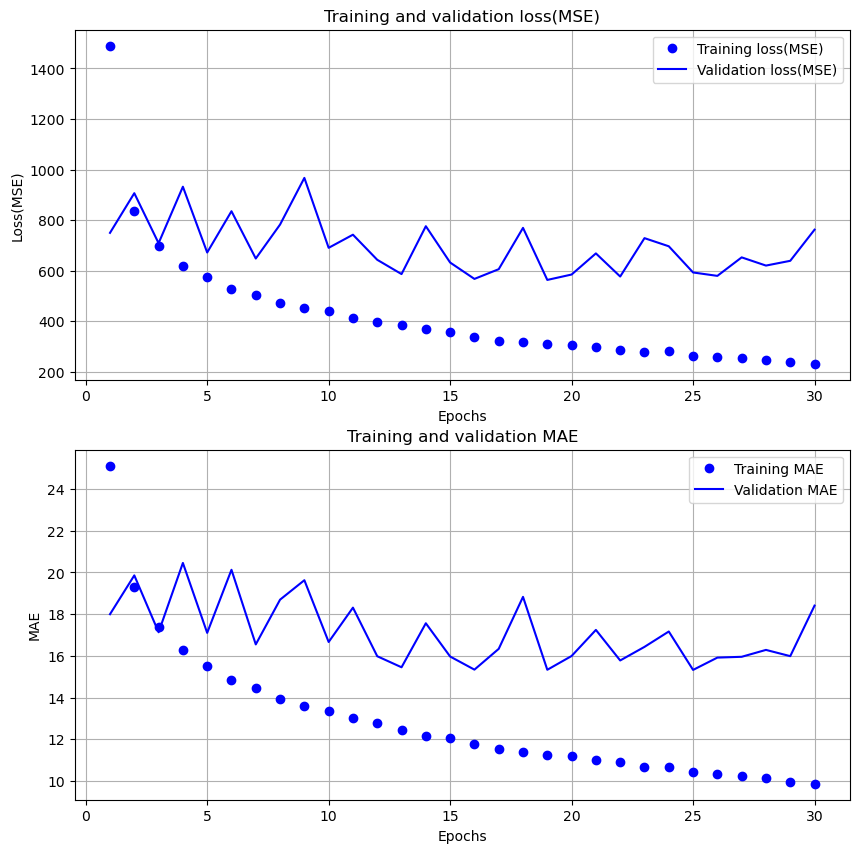

In [31]:
plot_history(history)

Continuing the training with extra epochs

Epoch 1/50
501/501 [==============================] - 3s 6ms/step - loss: 232.7421 - mae: 9.8026 - val_loss: 612.4210 - val_mae: 16.0604
Epoch 2/50
501/501 [==============================] - 3s 6ms/step - loss: 225.6560 - mae: 9.7459 - val_loss: 607.5326 - val_mae: 15.9766
Epoch 3/50
501/501 [==============================] - 3s 7ms/step - loss: 227.2659 - mae: 9.6351 - val_loss: 576.0599 - val_mae: 15.6405
Epoch 4/50
501/501 [==============================] - 3s 7ms/step - loss: 223.4638 - mae: 9.6042 - val_loss: 563.8018 - val_mae: 15.6902
Epoch 5/50
501/501 [==============================] - 3s 6ms/step - loss: 218.0335 - mae: 9.4948 - val_loss: 616.2703 - val_mae: 16.1457
Epoch 6/50
501/501 [==============================] - 3s 6ms/step - loss: 213.2863 - mae: 9.3805 - val_loss: 591.4771 - val_mae: 15.9957
Epoch 7/50
501/501 [==============================] - 3s 6ms/step - loss: 211.2575 - mae: 9.3530 - val_loss: 632.2112 - val_mae: 16.6052
Epoch 8/50
501/501 [=====================

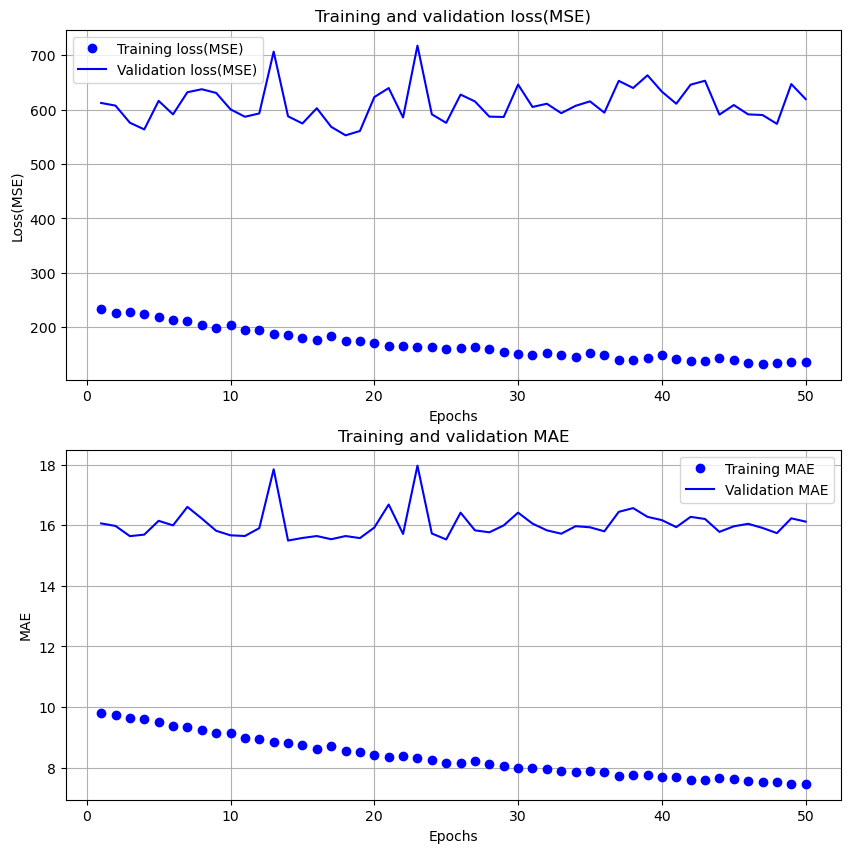

In [32]:
history = model.fit(train_data,
                    train_targets,
                    validation_split=0.2,
                    epochs=50,
                    shuffle=True,
                    batch_size=64,
                    callbacks=callbacks)
plot_history(history)


Epoch 1/100
251/251 [==============================] - 2s 7ms/step - loss: 119.0446 - mae: 7.1077 - val_loss: 602.3425 - val_mae: 15.8434
Epoch 2/100
251/251 [==============================] - 2s 7ms/step - loss: 117.4204 - mae: 7.0322 - val_loss: 595.1701 - val_mae: 15.8009
Epoch 3/100
251/251 [==============================] - 2s 7ms/step - loss: 110.7936 - mae: 6.9432 - val_loss: 659.3162 - val_mae: 16.4476
Epoch 4/100
251/251 [==============================] - 2s 7ms/step - loss: 115.2840 - mae: 6.9318 - val_loss: 599.5334 - val_mae: 15.7601
Epoch 5/100
251/251 [==============================] - 2s 7ms/step - loss: 111.2474 - mae: 6.8982 - val_loss: 750.1820 - val_mae: 17.3328
Epoch 6/100
251/251 [==============================] - 2s 6ms/step - loss: 110.0548 - mae: 6.8158 - val_loss: 604.3765 - val_mae: 16.0036
Epoch 7/100
251/251 [==============================] - 1s 6ms/step - loss: 108.4213 - mae: 6.8502 - val_loss: 650.3553 - val_mae: 16.3176
Epoch 8/100
251/251 [=============

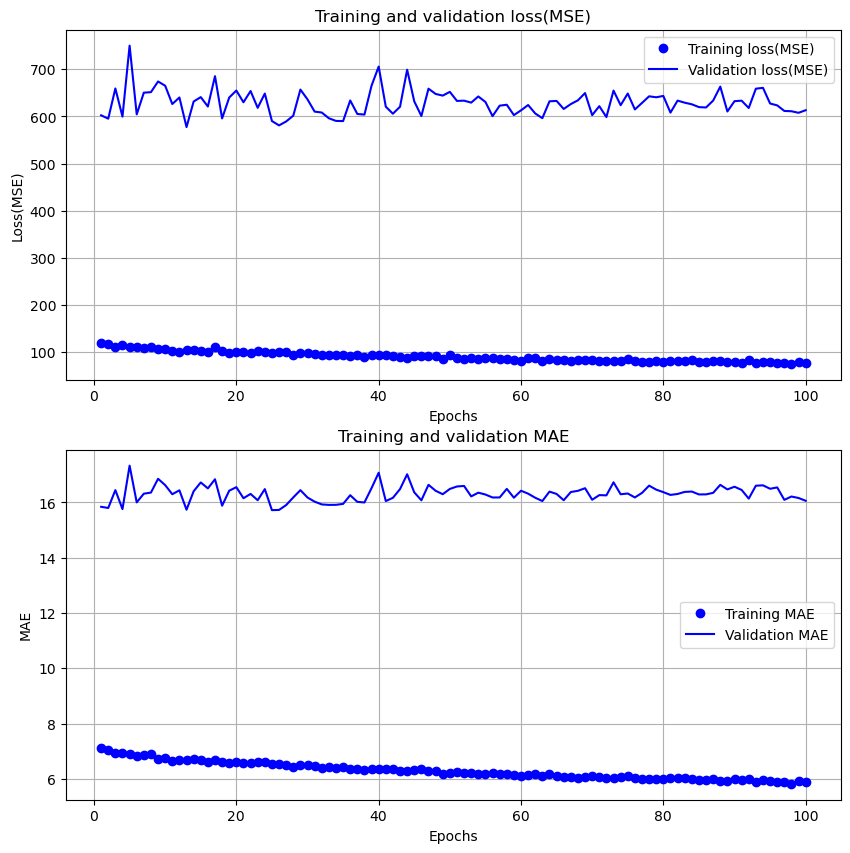

In [33]:
history = model.fit(train_data,
                    train_targets,
                    validation_split=0.2,
                    epochs=100,
                    shuffle=True,
                    batch_size=128,
                    callbacks=callbacks)

plot_history(history)


## Evaluating the model on test data

In [34]:
model = keras.models.load_model(os.path.join(
    MODELS_DIR, 'MLP_arch_without_feature_selection.keras'))

test_predictions = model.predict(test_data)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

2480/2480 [==============================] - 8s 3ms/step - loss: 3536.2559 - mae: 46.7413


### Saving the results

In [35]:
results_df = pd.DataFrame({'Actual': test_targets.numpy().flatten(),
                          'Predicted': test_predictions.flatten(), 'Error':
                              test_targets.numpy().flatten() -
                              test_predictions.flatten()})

results_df.head(10)


,Actual,Predicted,Error
0,0.000000,89.819199,-89.819199
1,76.500000,99.777489,-23.277489
2,68.000000,77.171631,-9.171631
3,76.500000,97.032112,-20.532112
4,76.500000,101.316719,-24.816719
5,76.500000,97.871498,-21.371498
6,58.669998,75.750450,-17.080452
7,68.000000,77.428299,-9.428299
8,76.500000,100.004738,-23.504738
9,76.500000,100.004738,-23.504738


In [36]:
results_df.to_csv(os.path.join(RESULTS_DIR, 'Results.csv'), index=False)


## Feature Selection Using Random Forest

In [37]:
rnd_frst_clf = RandomForestRegressor(random_state=42)
rnd_frst_clf.fit(train_data_pd, train_targets_pd)

RandomForestRegressor(random_state=42)

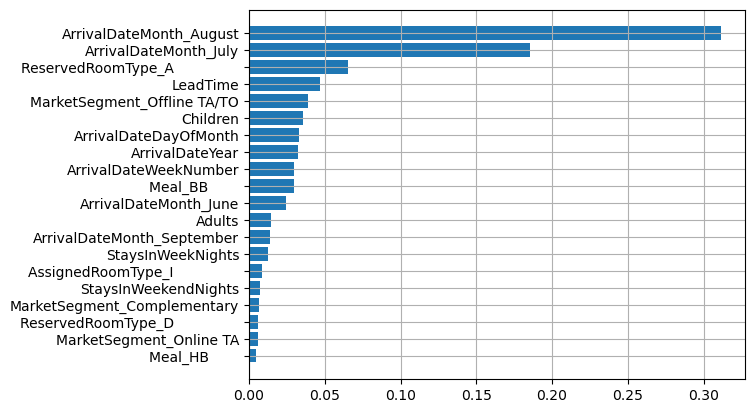

In [38]:
feat_ind = list(zip(train_data_pd.columns, rnd_frst_clf.feature_importances_))
feat_ind.sort(key=lambda x: x[1])
plt.barh([x[0] for x in feat_ind[-20:]], [x[1] for x in feat_ind[-20:]])
plt.grid()
plt.show()

In [39]:
test_data_pd.columns

Index(['IsCanceled', 'LeadTime', 'ArrivalDateYear', 'ArrivalDateWeekNumber',
       'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights',
       'Adults', 'Children', 'Babies',
       ...
       'DepositType_No Deposit     ', 'DepositType_Non Refund     ',
       'DepositType_Refundable     ', 'CustomerType_Contract',
       'CustomerType_Group', 'CustomerType_Transient',
       'CustomerType_Transient-Party', 'ReservationStatus_Canceled',
       'ReservationStatus_Check-Out', 'ReservationStatus_No-Show'],
      dtype='object', length=200)

In [40]:
selected_features = [x[0] for x in feat_ind if x[1] > 0.005]

train_data = tf.convert_to_tensor(train_data_pd[selected_features].values,
                                  dtype=tf.float32)
test_data = tf.convert_to_tensor(test_data_pd[selected_features].values,
                                 dtype=tf.float32)

mean = np.mean(train_data, axis=0)
train_data -= mean

std = np.std(train_data, axis=0)
train_data /= std

test_data -= mean
test_data /= std


In [41]:
selected_features

['MarketSegment_Online TA',
 'ReservedRoomType_D               ',
 'MarketSegment_Complementary',
 'StaysInWeekendNights',
 'AssignedRoomType_I               ',
 'StaysInWeekNights',
 'ArrivalDateMonth_September',
 'Adults',
 'ArrivalDateMonth_June',
 'Meal_BB       ',
 'ArrivalDateWeekNumber',
 'ArrivalDateYear',
 'ArrivalDateDayOfMonth',
 'Children',
 'MarketSegment_Offline TA/TO',
 'LeadTime',
 'ReservedRoomType_A               ',
 'ArrivalDateMonth_July',
 'ArrivalDateMonth_August']

Epoch 1/30
501/501 [==============================] - 6s 8ms/step - loss: 1301.5597 - mae: 24.1421 - val_loss: 1263.4327 - val_mae: 25.8444
Epoch 2/30
501/501 [==============================] - 4s 7ms/step - loss: 883.2405 - mae: 20.0845 - val_loss: 882.5543 - val_mae: 19.7760
Epoch 3/30
501/501 [==============================] - 4s 7ms/step - loss: 771.4357 - mae: 18.4006 - val_loss: 831.7172 - val_mae: 19.5812
Epoch 4/30
501/501 [==============================] - 4s 7ms/step - loss: 687.7680 - mae: 17.4931 - val_loss: 916.0728 - val_mae: 21.7227
Epoch 5/30
501/501 [==============================] - 4s 8ms/step - loss: 655.0814 - mae: 16.8164 - val_loss: 831.8439 - val_mae: 19.2580
Epoch 6/30
501/501 [==============================] - 4s 7ms/step - loss: 621.8638 - mae: 16.3313 - val_loss: 715.5396 - val_mae: 17.7613
Epoch 7/30
501/501 [==============================] - 3s 7ms/step - loss: 596.7383 - mae: 15.8800 - val_loss: 1115.3457 - val_mae: 23.3118
Epoch 8/30
501/501 [===========

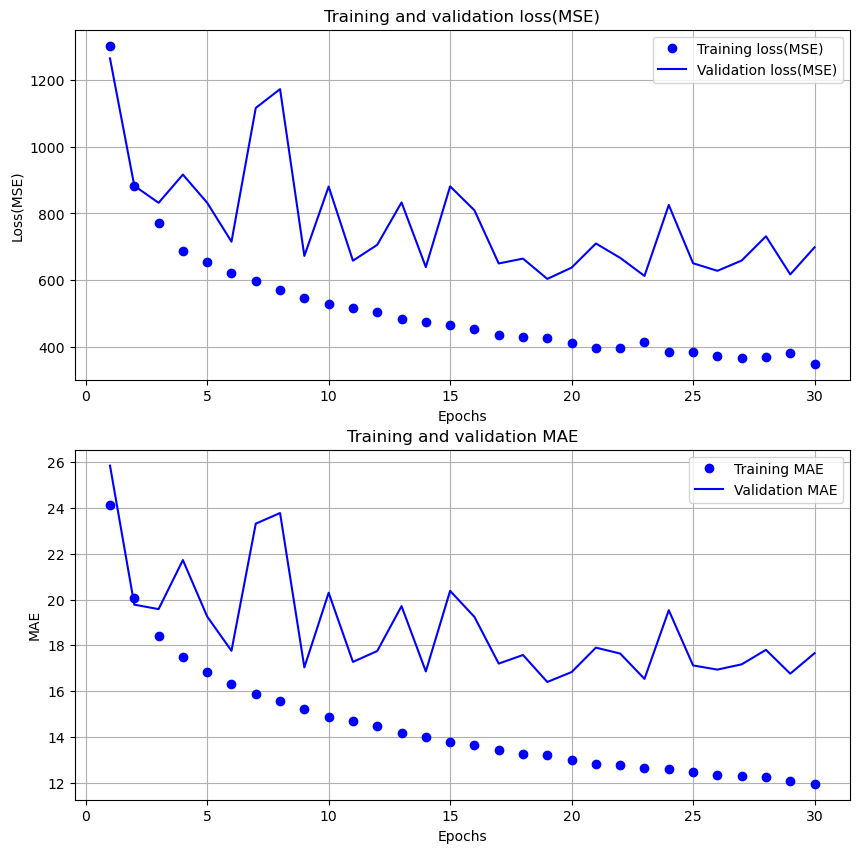

In [43]:
model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(MODELS_DIR,
                              'MLP_arch_without_feature_selection.keras'),
        save_best_only=True,
        monitor='val_loss')]
history = model.fit(train_data,
                    train_targets,
                    validation_split=0.2,
                    epochs=30,
                    shuffle=True,
                    batch_size=64,
                    callbacks=callbacks)
plot_history(history)


In [44]:
model.evaluate(test_data, test_targets)

2480/2480 [==============================] - 8s 3ms/step - loss: 2811.7849 - mae: 41.9411


[2811.784912109375, 41.9410514831543]

In [45]:
test_predictions = model.predict(test_data)
results_df = pd.DataFrame({'Actual': test_targets.numpy().flatten(),
                          'Predicted': test_predictions.flatten(), 'Error':
                              test_targets.numpy().flatten() -
                              test_predictions.flatten()})
results_df.to_csv(os.path.join(RESULTS_DIR, 'SelectedResults.csv'),
                  index=False)


2480/2480 [==============================] - 5s 2ms/step


## Importing the original data and working with it

In [124]:
data = pd.read_csv(os.path.join(DATA_DIR, 'hotel_bookings.csv'))
data.head()
data.isna().sum()


hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [125]:
data.drop(['company', 'agent', ], axis=1, inplace=True)
data.isna().sum()

hotel                               0
is_canceled                         0
lead_time                           0
arrival_date_year                   0
arrival_date_month                  0
arrival_date_week_number            0
arrival_date_day_of_month           0
stays_in_weekend_nights             0
stays_in_week_nights                0
adults                              0
children                            4
babies                              0
meal                                0
country                           488
market_segment                      0
distribution_channel                0
is_repeated_guest                   0
previous_cancellations              0
previous_bookings_not_canceled      0
reserved_room_type                  0
assigned_room_type                  0
booking_changes                     0
deposit_type                        0
days_in_waiting_list                0
customer_type                       0
adr                                 0
required_car

In [126]:
data.dropna(inplace=True)

Shuffling the data

In [127]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)


In [128]:
(data['adr'] == 0.0).sum()


1938

Deleting zero target values

In [129]:
data.drop(data[data['adr'] == 0.0].index, inplace=True)

In [130]:
targets = data['adr']
data.drop(['adr'], axis=1, inplace=True)

categorical_columns = data.select_dtypes(include=['object']).columns
data = pd.get_dummies(data, columns=categorical_columns)
data.shape

(116960, 1179)

In [131]:
data = data.astype('float32')
targets = targets.astype('float32')


In [132]:
split_param = 0.7
train_data = data[:int(split_param * data.shape[0])]
train_targets = targets[:int(split_param * data.shape[0])]
test_data = data[int(split_param * data.shape[0]):]
test_targets = targets[int(split_param * data.shape[0]):]


Selecting the features using random forest

In [90]:
rnd_frst_clf = RandomForestRegressor(random_state=42,
                                     n_estimators=1000,
                                     max_features=1,
                                     max_depth=100,
                                     n_jobs=-1)

rnd_frst_clf.fit(train_data, train_targets)

RandomForestRegressor(max_depth=100, max_features=1, n_estimators=1000,
                      n_jobs=-1, random_state=42)

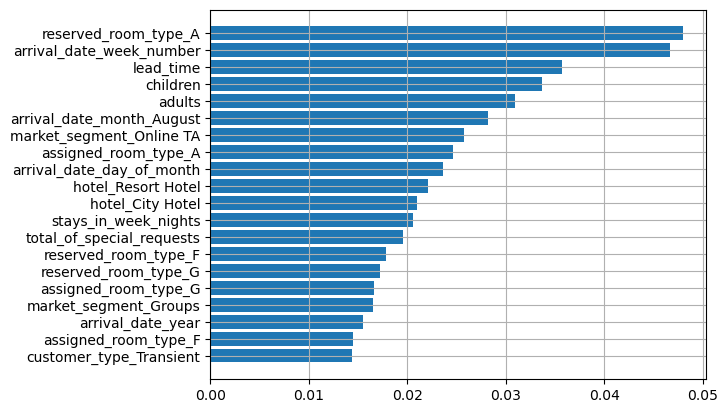

In [91]:
feat_ind = list(zip(train_data.columns, rnd_frst_clf.feature_importances_))
feat_ind.sort(key=lambda x: x[1])
plt.barh([x[0] for x in feat_ind[-20:]], [x[1] for x in feat_ind[-20:]])
plt.grid()
plt.show()

In [134]:
selected_features = [x[0] for x in feat_ind if x[1] > 0.005]

scalar = StandardScaler()
train_data_selected = scalar.fit_transform(train_data[selected_features])
test_data_selected = scalar.transform(test_data[selected_features])

train_data_selected = tf.convert_to_tensor(train_data_selected,
                                           dtype=tf.float32)
train_targets = tf.convert_to_tensor(train_targets, dtype=tf.float32)
test_data_selected = tf.convert_to_tensor(test_data_selected, dtype=tf.float32)
test_targets = tf.convert_to_tensor(test_targets, dtype=tf.float32)

train_data_selected.shape, test_data_selected.shape

(TensorShape([81872, 52]), TensorShape([35088, 52]))

In [93]:
def get_model(data):
    """
    Returns a compiled model.
    """
    initializer = tf.keras.initializers.HeNormal(seed=42)
    inputs = keras.Input(shape=(data.shape[1],))
    x = layers.Dense(32, activation='relu',
                     kernel_initializer=initializer)(inputs)
    x = layers.Dense(32, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(64, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(64, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(128, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(128, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(256, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(256, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(512, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(1024, activation='relu',
                     kernel_initializer=initializer)(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    return model


In [94]:
model = get_model(train_data_selected)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_93 (Dense)            (None, 32)                960       
                                                                 
 dense_94 (Dense)            (None, 32)                1056      
                                                                 
 dense_95 (Dense)            (None, 64)                2112      
                                                                 
 dense_96 (Dense)            (None, 64)                4160      
                                                                 
 dense_97 (Dense)            (None, 128)               8320      
                                                                 
 dense_98 (Dense)            (None, 128)               1651

In [95]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(
            MODELS_DIR,
            'MLP_arch_with_feature_selection_orgData.keras'),
        save_best_only=True,
        monitor='val_loss')]
history = model.fit(train_data_selected,
                    train_targets,
                    validation_split=0.2,
                    epochs=80,
                    shuffle=True,
                    batch_size=64,
                    callbacks=callbacks)


Epoch 1/80
1024/1024 [==============================] - 9s 7ms/step - loss: 1387.1934 - mae: 27.3391 - val_loss: 1737.6211 - val_mae: 32.9267
Epoch 2/80
1024/1024 [==============================] - 7s 7ms/step - loss: 841.2778 - mae: 21.1293 - val_loss: 1257.3058 - val_mae: 26.6180
Epoch 3/80
1024/1024 [==============================] - 7s 7ms/step - loss: 695.9453 - mae: 18.8506 - val_loss: 862.5567 - val_mae: 20.8796
Epoch 4/80
1024/1024 [==============================] - 7s 7ms/step - loss: 602.0790 - mae: 17.3224 - val_loss: 969.1127 - val_mae: 22.4555
Epoch 5/80
1024/1024 [==============================] - 7s 7ms/step - loss: 566.0299 - mae: 16.6502 - val_loss: 471.5379 - val_mae: 15.6328
Epoch 6/80
1024/1024 [==============================] - 7s 7ms/step - loss: 520.3618 - mae: 15.8342 - val_loss: 494.8341 - val_mae: 15.3052
Epoch 7/80
1024/1024 [==============================] - 7s 7ms/step - loss: 497.2469 - mae: 15.3807 - val_loss: 507.5637 - val_mae: 15.2743
Epoch 8/80
1024/1

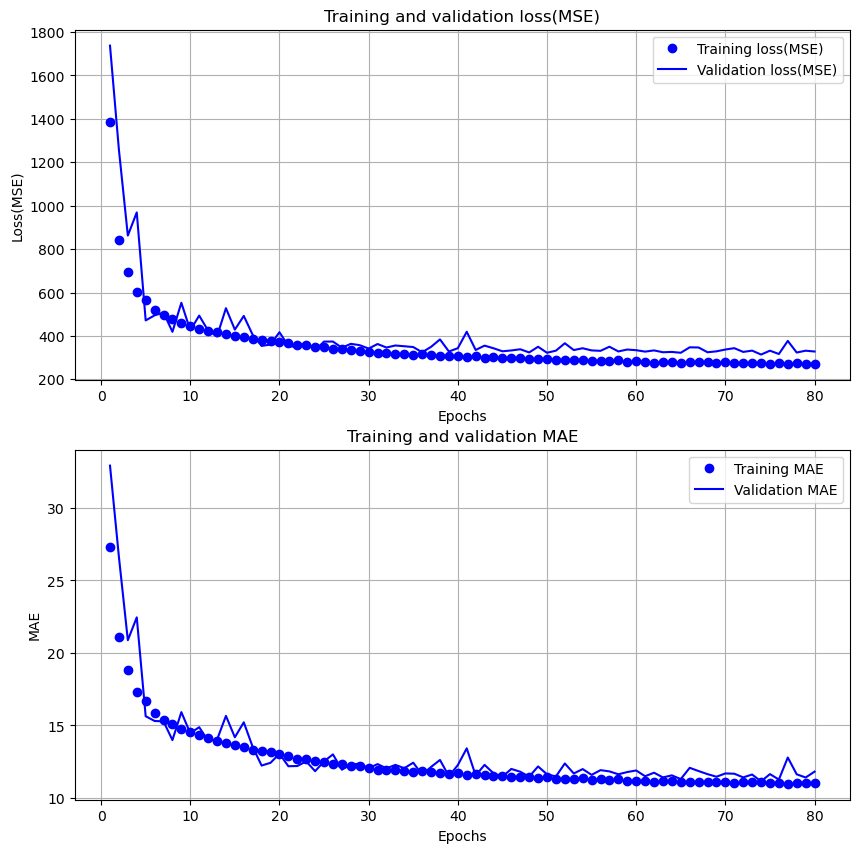

1097/1097 [==============================] - 2s 2ms/step


In [96]:
plot_history(history)

test_predictions = model.predict(test_data_selected)
results_df = pd.DataFrame({'Actual': test_targets.numpy().flatten(),
                          'Predicted': test_predictions.flatten(), 'Error':
                              test_targets.numpy().flatten() -
                              test_predictions.flatten()})
results_df.to_csv(os.path.join(
    RESULTS_DIR,
    'SelectedFeaturesResults_OriginalData.csv'),
    index=False)


In [97]:
model = keras.models.load_model(os.path.join(
    MODELS_DIR, 'MLP_arch_with_feature_selection_orgData.keras'))
model.evaluate(test_data_selected, test_targets)

1097/1097 [==============================] - 4s 3ms/step - loss: 1132.1180 - mae: 11.3399


[1132.1180419921875, 11.33991813659668]

## Feature Extraction using Autoencoders

### Scaling the data and importing to tensor

In [103]:
scalar = StandardScaler()
train_data = scalar.fit_transform(train_data)
test_data = scalar.transform(test_data)

train_data = tf.convert_to_tensor(train_data, dtype=tf.float32)
train_targets = tf.convert_to_tensor(train_targets, dtype=tf.float32)
test_data = tf.convert_to_tensor(test_data, dtype=tf.float32)
test_targets = tf.convert_to_tensor(test_targets, dtype=tf.float32)

train_data_selected.shape, test_data_selected.shape

(TensorShape([81872, 1179]), TensorShape([35088, 1179]))

### Designing the autoencoder

In [139]:
from keras.layers import Input, Dense
from keras.models import Model


inputs = Input(shape=(train_data_selected.shape[1],))
x = Dense(42, activation='relu')(inputs)
encoded = Dense(32, activation='relu')(x)
x = Dense(42, activation='relu')(encoded)
decoded = Dense(train_data_selected.shape[1], activation='relu')(encoded)

autoencoder = Model(inputs, decoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(train_data_selected,
                train_data_selected,
                epochs=10,
                batch_size=64,
                shuffle=True,
                validation_split=0.2)

encoder = Model(inputs, encoded)

train_data_encoded = encoder.predict(train_data_selected)
test_data_encoded = encoder.predict(test_data_selected)

Epoch 1/10
1024/1024 [==============================] - 5s 5ms/step - loss: 0.5652 - val_loss: 0.4348
Epoch 2/10
1024/1024 [==============================] - 4s 4ms/step - loss: 0.4213 - val_loss: 0.4147
Epoch 3/10
1024/1024 [==============================] - 4s 4ms/step - loss: 0.4103 - val_loss: 0.4079
Epoch 4/10
1024/1024 [==============================] - 4s 4ms/step - loss: 0.4058 - val_loss: 0.4059
Epoch 5/10
1024/1024 [==============================] - 4s 4ms/step - loss: 0.4043 - val_loss: 0.4049
Epoch 6/10
1024/1024 [==============================] - 4s 4ms/step - loss: 0.4037 - val_loss: 0.4047
Epoch 7/10
1024/1024 [==============================] - 4s 4ms/step - loss: 0.4034 - val_loss: 0.4042
Epoch 8/10
1024/1024 [==============================] - 4s 4ms/step - loss: 0.4032 - val_loss: 0.4042
Epoch 9/10
1024/1024 [==============================] - 4s 4ms/step - loss: 0.4030 - val_loss: 0.4042
Epoch 10/10
1097/1097 [==============================] - 1s 1ms/step


### Training the model

In [142]:
def get_model(data):
    """
    Returns a compiled model.
    """
    initializer = tf.keras.initializers.HeNormal(seed=42)
    inputs = keras.Input(shape=(data.shape[1],))
    x = layers.Dense(32, activation='relu',
                     kernel_initializer=initializer)(inputs)
    x = layers.Dense(32, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(64, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(64, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(64, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(128, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(128, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(256, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(256, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dense(512, activation='relu', kernel_initializer=initializer)(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(1024, activation='relu',
                     kernel_initializer=initializer)(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='rmsprop',
                  loss='mse',
                  metrics=['mae'])

    return model


In [143]:
model = get_model(train_data_encoded)
model.summary()

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 32)]              0         
                                                                 
 dense_214 (Dense)           (None, 32)                1056      
                                                                 
 dense_215 (Dense)           (None, 32)                1056      
                                                                 
 dense_216 (Dense)           (None, 64)                2112      
                                                                 
 dense_217 (Dense)           (None, 64)                4160      
                                                                 
 dense_218 (Dense)           (None, 64)                4160      
                                                                 
 dense_219 (Dense)           (None, 128)               832

In [144]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=os.path
        .join(MODELS_DIR,
              'MLP_arch_with_feature_extraction_orgData.keras'),
        save_best_only=True,
        monitor='val_loss'),
    ]

history = model.fit(train_data_encoded,
                    train_targets,
                    validation_split=0.2,
                    epochs=80,
                    batch_size=64,
                    callbacks=callbacks)


Epoch 1/80
1024/1024 [==============================] - 10s 8ms/step - loss: 1898.2325 - mae: 32.6847 - val_loss: 1515.3038 - val_mae: 28.5964
Epoch 2/80
1024/1024 [==============================] - 8s 7ms/step - loss: 1154.8221 - mae: 24.9244 - val_loss: 1567.2020 - val_mae: 29.3486
Epoch 3/80
1024/1024 [==============================] - 7s 7ms/step - loss: 899.4567 - mae: 21.5940 - val_loss: 779.2338 - val_mae: 19.9620
Epoch 4/80
1024/1024 [==============================] - 8s 8ms/step - loss: 809.9382 - mae: 20.2978 - val_loss: 627.6367 - val_mae: 18.1801
Epoch 5/80
1024/1024 [==============================] - 7s 7ms/step - loss: 744.8826 - mae: 19.4165 - val_loss: 785.0725 - val_mae: 19.4171
Epoch 6/80
1024/1024 [==============================] - 7s 7ms/step - loss: 706.5140 - mae: 18.8813 - val_loss: 618.8379 - val_mae: 18.3771
Epoch 7/80
1024/1024 [==============================] - 8s 7ms/step - loss: 674.4712 - mae: 18.3944 - val_loss: 795.8595 - val_mae: 21.1168
Epoch 8/80
1024

### Evaluating the model

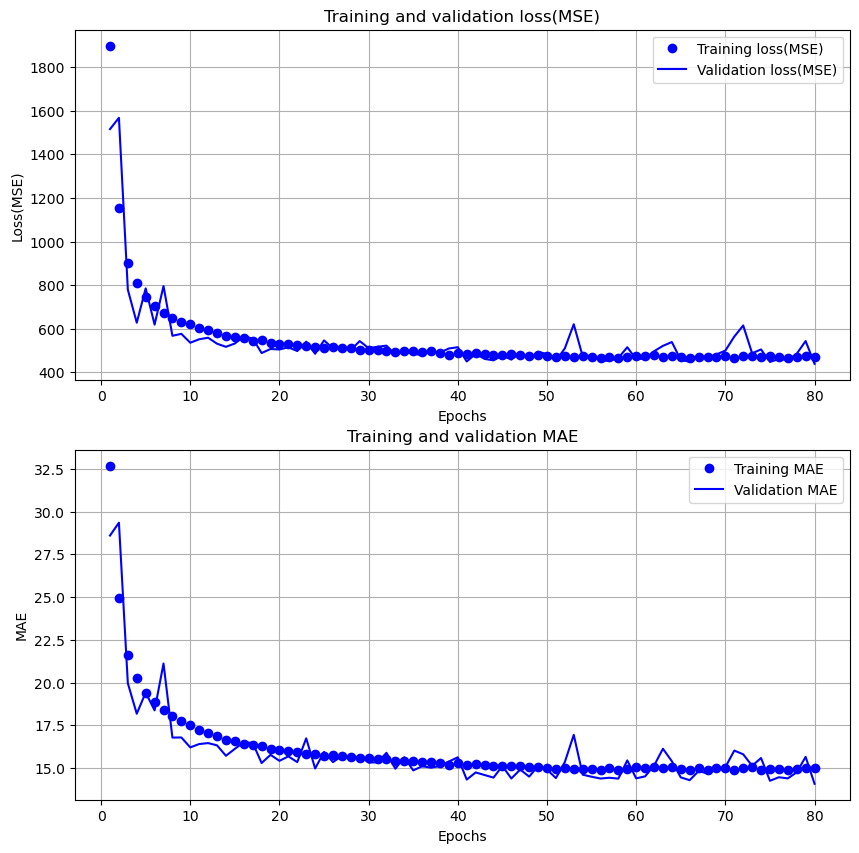

1097/1097 [==============================] - 2s 2ms/step


In [145]:
plot_history(history)
model = keras.models.load_model(os.path.join(
    MODELS_DIR, 'MLP_arch_with_feature_extraction_orgData.keras'))
test_predictions = model.predict(test_data_encoded)
results_df = pd.DataFrame({'Actual': test_targets.numpy().flatten(),
                          'Predicted': test_predictions.flatten(), 'Error':
                              test_targets.numpy().flatten() -
                              test_predictions.flatten()})
results_df.to_csv(os.path.join(RESULTS_DIR, 'EncodedFeaturesResults_OriginalData.csv'),
                  index=False)


In [146]:
model.evaluate(test_data_encoded, test_targets)

1097/1097 [==============================] - 4s 4ms/step - loss: 1254.5999 - mae: 14.3070


[1254.599853515625, 14.306970596313477]

: 